In [38]:
import numpy as np
import pandas as pd
from groq import Groq
import os
import time

In [39]:
response = pd.read_excel('../../dataframes/llama3-70B-OMIEC190824_0.3_temp_dict2_RESPONSES.xlsx')
raw_data =  pd.read_excel('../../data/raw/OMIEC_19_08_24.xlsx')

In [40]:
nan_count = response.isna().sum()
print(nan_count)

index         0
response    532
dtype: int64


In [41]:
result = pd.concat([response, raw_data], axis=1)
result.drop('index', axis=1, inplace=True)

In [42]:
response = response.dropna()
responses_cleaned = response[response['response'] != '{}']
responses_cleaned = responses_cleaned[responses_cleaned['response'] != 'None']

In [43]:
import re
import json

def prepare_dict(df):
    
    all_dicts = []
    index_nones = []
    for index, row in df.iterrows():
        try:
            if "PEDOT: PSS" in row['response']:
               row['response'] = row['response'].replace("PEDOT: PSS", "PEDOT:PSS")
            
            if "'Doped?:' " in row['response']:
                dicts = row['response'].strip().replace("'Doped?:'", "'Doped?':").rstrip(';').split(';')
            else:
                dicts = row['response'].strip().rstrip(';').split(';')
                
            dicts = [d.strip().replace("'", '"') for d in dicts]
            json_data = f"[{','.join(dicts)}]"
            dictt = json.loads(json_data)
        except Exception as e:
            print(index, '\n', row['response'], '\n')
            #print(row['response'].replace("'Doped?:'", "'Doped?':"))
            
        for polymer in dictt:
            #polymer['Index'] = index 
            if "Doped?:" in polymer:
                polymer["Doped?"] = polymer.pop("Doped?:")

            if 'Polymer Chemical Abbreviation' not in polymer:
                key = list(polymer.keys())[0]
                polymer['Polymer Chemical Abbreviation'] = polymer[key]
                
            if 'Polymer Mentioned Name' not in polymer:
                polymer['Polymer Mentioned Name'] = list(polymer.keys())[0]
                
            new_dict = {index: polymer}
            
            all_dicts.append(new_dict)
    
    return all_dicts, index_nones



In [44]:

polymer_dicts, _ = prepare_dict(responses_cleaned)

polymers = []

for polymer in polymer_dicts:
    print(polymer[list(polymer.keys())[0]])
    polymers.append(polymer[list(polymer.keys())[0]]['Polymer Chemical Abbreviation'])


188 
 {(La,Si)(Co,Fe)O(3-delta): (La,Si)(Co,Fe)O(3-delta), Cathode, Not Doped} 

301 
 {(C6H10N2)PbI4: '(C6H10N2)PbI4', 'Polymer Chemical Abbreviation': '(C6H10N2)PbI4', 'Polymer Application': 'solar cells, light-emitting devices', 'Doped?:': 'not doped'};{(C6H10N2)(6)IPb5I21 center dot 3H(2)O: '(C6H10N2)(6)IPb5I21 center dot 3H(2)O', 'Polymer Chemical Abbreviation': '(C6H10N2)(6)IPb5I21 center dot 3H(2)O', 'Polymer Application': 'solar cells, light-emitting devices', 'Doped?:': 'not doped'} 

494 
 {(La,Sr)(Co,Fe)O-3: (La,Sr)(Co,Fe)O-3, 'Polymer Chemical Abbreviation': LSCF, 'Polymer Application': model mixed conducting cathode material, 'Doped?:': not doped}; 

547 
 {(La, Sr)(Co, Fe)O(3): (La, Sr)(Co, Fe)O(3), 'model-mixed conducting cathode material, cathode'; } 

865 
 {naphthalene bis-isatin dimer: naphthalene bis-isatin dimer, Polymeric Chemical Abbreviation: NBID, Polymer Application: organic electrochemical transistors, Doped?: n-doped};{gNR: gNR, Polymeric Chemical Abbreviati

In [45]:
# Função para encontrar a interseção entre dois conjuntos de polímeros
def verificar_interseccao(p1, p2):
    conjunto1 = {p1['Polymer Chemical Abbreviation'].replace('/', '-').replace(':', '-').lower(),
                 p1['Polymer Mentioned Name'].replace('/', '-').replace(':', '-').lower()}
    conjunto2 = {p2['Polymer Chemical Abbreviation'].replace('/', '-').replace(':', '-').lower(),
                 p2['Polymer Mentioned Name'].replace('/', '-').replace(':', '-').lower()}
    return not conjunto1.isdisjoint(conjunto2)

# Agrupar polímeros com base na interseção
def agrupar_polimeros(polimeros):
    grupos = []
    visitados = set()
    
    for i, dados1 in enumerate(polimeros):
        
        if i in visitados:
            continue
        
        grupo_atual = set()
        grupo_nome_atual = []
        
        # Adicionar o polímero atual ao grupo
        grupo_atual.add(i)
        grupo_nome_atual.append([dados1[list(dados1.keys())[0]]['Polymer Chemical Abbreviation'], list(dados1.keys())[0]])
        visitados.add(i)
        
        # Comparar com elementos subsequentes
        for j in range(i + 1, len(polimeros)):
            dados2 = polimeros[j]
            if verificar_interseccao(dados1[list(dados1.keys())[0]], dados2[list(dados2.keys())[0]]):
                grupo_atual.add(j)
                grupo_nome_atual.append([dados2[list(dados2.keys())[0]]['Polymer Chemical Abbreviation'], list(dados2.keys())[0]])
                visitados.add(j)
        
        grupos.append(grupo_nome_atual)
    
    return grupos


grupos_nomes_encontrados = agrupar_polimeros(polymer_dicts)
#grupos_nomes_encontrados = sorted(grupos_nomes_encontrados, key=len, reverse=True)
grupos_nomes = [list(map(list, set(map(tuple, grupo)))) for _, grupo in enumerate(grupos_nomes_encontrados, start=1)]
grupos_nomes = sorted(grupos_nomes, key=len, reverse=True)
soma = 0

for i, grupo in enumerate(grupos_nomes, start=1):
    soma += len(grupo)
    #print(f"{grupo[0][0]}: {len(grupo)}")
print(f"Quantidade polímeros: {soma} | Quantidade polímeros únicos: {len(grupos_nomes)}")


Quantidade polímeros: 1059 | Quantidade polímeros únicos: 426


In [46]:
items_to_remove = [r'(?i)\bmixed\b',
                   r'(?i)\bnone\b',
                   r'MIEC.*',
                   'based', 
                   r'[Pp]olymer',
                   r'OECT.*',
                   'conjug',
                   r'^$', 
                   r'^PSS$'
                   ]


In [47]:

print("Polímeros identificados antes:", len(grupos_nomes))
for item in items_to_remove:
    for p in grupos_nomes:
        pattern = re.compile(item)
        if pattern.search(p[0][0]):
            #print(item, '\n', p)
            grupos_nomes.remove(p)

print("Polímeros identificados após remoção:",len(grupos_nomes))

Polímeros identificados antes: 426
Polímeros identificados após remoção: 416


In [48]:
df = []
for i,grupo in enumerate(grupos_nomes, start=1):
    linha_df = {'Nome': grupo[0][0], 'Quantidade_Encontrada': len(grupo), 'Identificação_Encontrados': grupo}
    df.append(linha_df)
polímeros_estruturados = pd.DataFrame(df)
polímeros_estruturados

,Nome,Quantidade_Encontrada,Identificação_Encontrados
0,PEDOT:PSS,212,"[[PEDOT:PSS, 977], [PEDOT:PSS, 275], [PEDOT:PS..."
1,PEDOT,113,"[[PEDOT, 881], [PEDOT, 399], [PEDOT, 945], [PE..."
2,P3HT,32,"[[P3HT, 1478], [P3HT, 1362], [P3HT, 47], [P3HT..."
3,BBL,13,"[[BBL, 733], [BBL, 1273], [BBL, 1112], [BBL, 6..."
4,PPy,13,"[[PPy, 1389], [PPy, 845], [PPY, 1206], [Ppy, 1..."
...,...,...,...
411,PT-COOH,1,"[[PT-COOH, 1562]]"
412,PT-OH,1,"[[PT-OH, 1562]]"
413,BT-TT,1,"[[BT-TT, 1566]]"
414,DPPDTT,1,"[[DPPDTT, 1571]]"


C:\Users\thaynara220042\AppData\Local\Temp\ipykernel_1532\2917285224.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=polímeros_estruturados[:10]['Quantidade_Encontrada'], y=polímeros_estruturados[:10]['Nome'], palette="viridis")


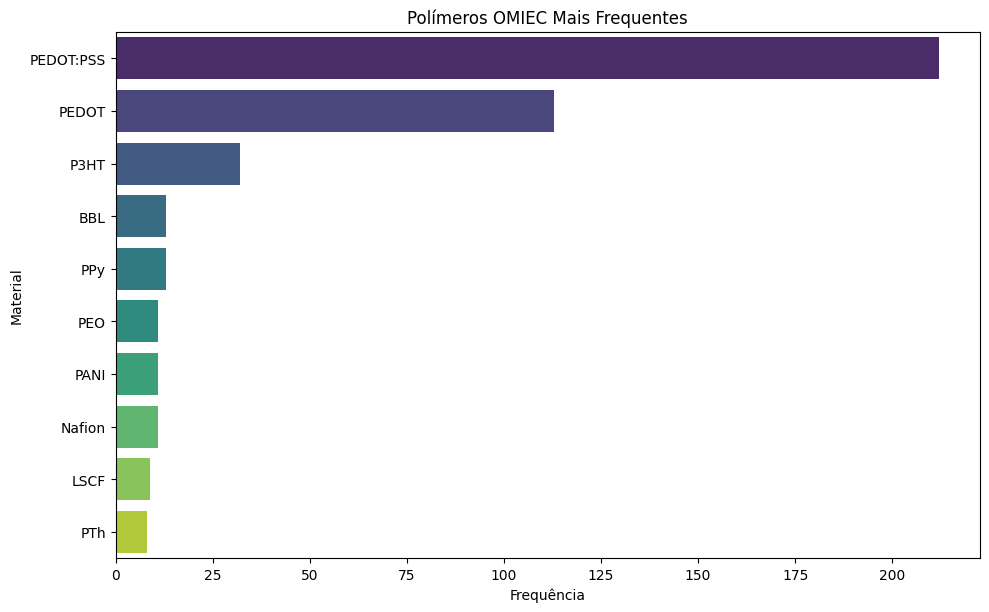

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


sns.barplot(x=polímeros_estruturados[:10]['Quantidade_Encontrada'], y=polímeros_estruturados[:10]['Nome'], palette="viridis")
plt.xlabel('Frequência')
plt.ylabel('Material')

# Ajustando layout para não cortar legendas
plt.tight_layout()
plt.title('Polímeros OMIEC Mais Frequentes')
# Salvando a imagem
#plt.savefig('gráficos/llama3-70B-OMIEC190824_RESPONSES_ranking.png')

# Exibindo a imagem
plt.show()


Tendência de publicações sobre a temática durante os anos

C:\Users\thaynara220042\AppData\Local\Temp\ipykernel_1532\3684753008.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


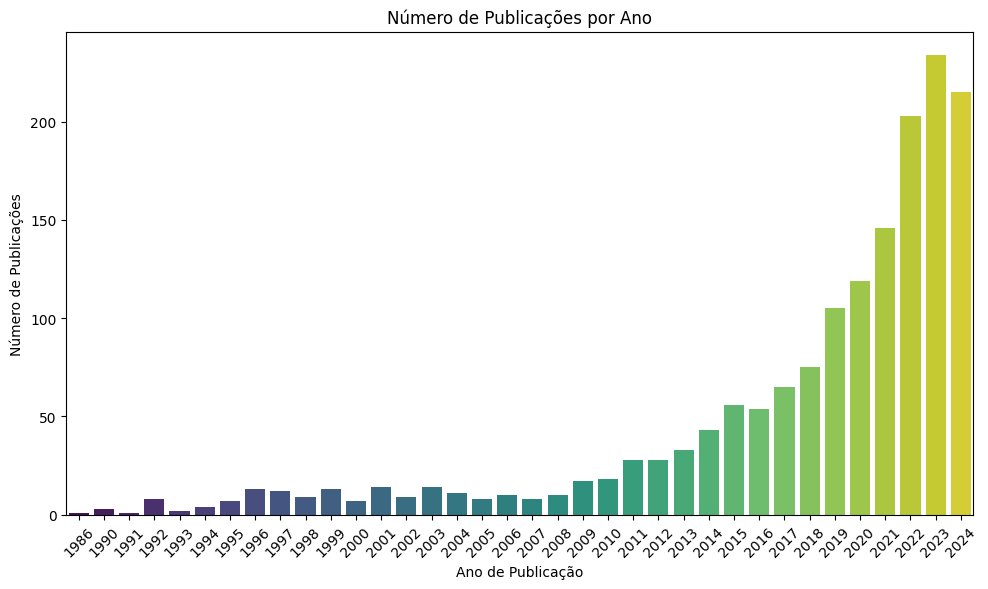

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Seaborn usando a paleta "viridis"
plt.figure(figsize=(10, 6))
sns.barplot(
    x=publication_counts.index, 
    y=publication_counts.values, 
    palette="viridis"  # Aplica a paleta de cores "viridis"
)

# Configurar o título e os rótulos dos eixos
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano de Publicação')
plt.ylabel('Número de Publicações')

# Mostrar o gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor visualização

# Ajustando layout para não cortar legendas
plt.tight_layout()

# Salvando a imagem
#plt.savefig('gráficos/llama3-70B-OMIEC160824_publicação_por_ano.png')

plt.show()


### Localizando os artigos em que aparecem os polímeros

In [51]:
busca = 'BBL'

resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == busca]
for ID in list(resultado['Identificação_Encontrados'])[0]:
    print(busca,"| Citações:", raw_data.loc[ID[1]]['Times Cited, All Databases'] , '\n', raw_data.loc[ID[1]]['Abstract'], '\n')

BBL | Citações: 13 
 Organic electrochemical transistors (OECTs) have the potential to revolutionize the field of organic bioelectronics. To date, most of the reported OECTs include p-type (semi-)conducting polymers as the channel material, while n-type OECTs are yet at an early stage of development, with the best performing electron-transporting materials still suffering from low transconductance, low electron mobility, and slow response time. Here, the high electrical conductivity of multi-walled carbon nanotubes (MWCNTs) and the large volumetric capacitance of the ladder-type pi-conjugated redox polymer poly(benzimidazobenzophenanthroline) (BBL) are leveraged to develop n-type OECTs with record-high performance. It is demonstrated that the use of MWCNTs enhances the electron mobility by more than one order of magnitude, yielding fast transistor transient response (down to 15 ms) and high mu C* (electron mobility x volumetric capacitance) of about 1 F cm(-1) V-1 s(-1). This enables t

### Frequência de publicação para TOP5 polímeros

In [52]:
dfs = []

for polymer in polímeros_estruturados[:5]['Nome']:
    resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == polymer]
    lista_ids = [ID[1] for ID in list(resultado['Identificação_Encontrados'])[0]]
    publication_counts = raw_data.iloc[lista_ids]['Publication Year'].value_counts()
    publication_counts = publication_counts.sort_index().reset_index()
    publication_counts.columns = ['Year', 'Count']
    publication_counts['Polymer'] = polymer
    dfs.append(publication_counts)

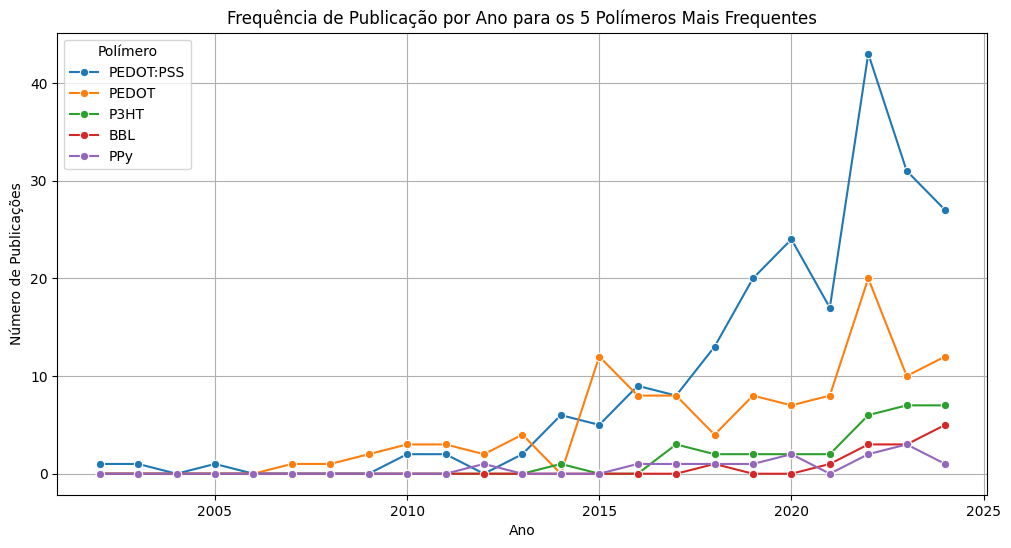

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dfs = []

for polymer in polímeros_estruturados[:5]['Nome']:
    resultado = polímeros_estruturados.loc[polímeros_estruturados['Nome'] == polymer]
    lista_ids = [ID[1] for ID in list(resultado['Identificação_Encontrados'])[0]]
    publication_counts = raw_data.iloc[lista_ids]['Publication Year'].value_counts()
    publication_counts = publication_counts.sort_index().reset_index()
    publication_counts.columns = ['Year', 'Count']
    publication_counts['Polymer'] = polymer
    dfs.append(publication_counts)
    
combined_df = pd.concat(dfs)

# Definir o intervalo de anos que você deseja garantir
anos_desejados = range(combined_df['Year'].min(), combined_df['Year'].max() + 1)

# Criar um DataFrame de referência com todos os anos para cada polímero
reference_df = pd.DataFrame([(polymer, year) for polymer in combined_df['Polymer'].unique() for year in anos_desejados], columns=['Polymer', 'Year'])

# Mesclar com o DataFrame combinado para garantir que todos os anos estejam presentes
combined_df = pd.merge(reference_df, combined_df, on=['Polymer', 'Year'], how='left').fillna(0)

# Plotar os dados
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='Year', y='Count', hue='Polymer', marker='o')
plt.title('Frequência de Publicação por Ano para os 5 Polímeros Mais Frequentes')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.legend(title='Polímero')
plt.grid(True)

#plt.xlim(left=2010)

plt.savefig('gráficos/llama3-70B-OMIEC190824_freq_publicação_polimero.png')

plt.show()


### Demais análises

In [178]:
aplicações = []
for i in polymer_dicts:
    app = i[list(i.keys())[0]]['Polymer Application'].split(',')
    aplicações.extend(app)
    '''for f in app:
        if 'intermediate temperature solid oxide fuel cells' in f.lower():
            print(i, '\n')
            print(raw_data.loc[list(i.keys())[0]]['Abstract'], '\n')'''
print(len(aplicações))

2621


In [179]:
aplicações = pd.Series([a.lower().strip() for a in aplicações ])

In [180]:
len(np.unique(aplicações))

1175

In [181]:
replacements = {
    r"\borganic(?:\s+electrochemical(?:\s+transistors?)?)?\b|\belectrochemical\s+transistors?\b": 'oect',
    r"\b(oect|oects)\b(?:\s*.*)?[\)\']?" : 'oect'
}

for pattern, replacement in replacements.items():
    aplicações = aplicações.str.replace(pattern, replacement, regex=True, case=False)

In [182]:
len(np.unique(aplicações))

1126

In [183]:
aplicações.value_counts().head(20)

oect                                               472
bioelectronics                                      94
biosensors                                          55
biosensing                                          37
neuromorphic computing                              31
bioelectronic                                       24
biosensor                                           24
transistor                                          24
energy storage                                      22
bioelectronic devices                               20
cathode                                             19
sensors                                             17
neuromorphic devices                                16
wearable electronics                                15
sensing                                             14
wearable                                            14
                                                    12
cathode materials                                   12
thermoelec

Verificando que foi extraído sobre dopagem

In [185]:
dopado = []
for i in polymer_dicts:
    dop = i[list(i.keys())[0]]['Doped?'].split(',')
    dopado.extend(dop)
    '''for f in app:
        if 'intermediate temperature solid oxide fuel cells' in f.lower():
            print(i, '\n')
            print(raw_data.loc[list(i.keys())[0]]['Abstract'], '\n')'''
print(len(dopado))

1057


In [197]:
dopado = pd.Series([d.lower().strip().replace('-', ' ').replace('_', ' ').replace('type', 'doped') for d in dopado ])

In [202]:
items_to_remove = [ r'^$', 
                   r'(?i)\bnone\b'
                   ]

    
for item in items_to_remove:
    dopado = dopado[~dopado.str.contains(item, regex=True)]

In [204]:
len(np.unique(dopado))

21

In [203]:
dopado.value_counts().head(20)

not doped                  801
p doped                    142
n doped                     68
doped                       16
self doped                   5
acceptor doped               4
electrochemically doped      2
a site doped                 2
de doped                     2
acid (hcl) doped             1
ionic liquid doped           1
lithium ion doped            1
pss doped                    1
co doped                     1
donor doped                  1
sr doped                     1
dopant                       1
ambipolar                    1
y doped                      1
electrochemical doping       1
Name: count, dtype: int64

### Playground

In [55]:
import plotly.express as px

# Supondo que 'raw_data' seja o seu DataFrame e 'Publication Year' seja a coluna com os anos de publicação
publication_counts = raw_data['Publication Year'].value_counts()

# Ordenar os valores pela data para melhorar a visualização (opcional)
publication_counts = publication_counts.sort_index()

# Criar o gráfico de barras com Plotly
fig = px.bar(
    x=publication_counts.index, 
    y=publication_counts.values, 
    labels={'x': 'Publication Year', 'y': 'Number of Publications'},
    title='Number of Publications per Year',
    color=publication_counts.index,  # Adiciona cor baseado no índice (ano de publicação)
    color_continuous_scale='viridis'  # Aplica a paleta "viridis"
)

# Configurar o layout
fig.update_layout(
    xaxis=dict(tickangle=45),  # Rotaciona os rótulos do eixo x para melhor visualização
    yaxis_title='Number of Publications',
    xaxis_title='Publication Year',
    coloraxis_showscale=False  # Oculta a barra de escala de cores, se indesejado
)

# Mostrar o gráfico
fig.show()
